In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-02-27 13:34:07,227: Default instance: ibm-q/open/main


In [4]:
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True})
plt.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["figure.dpi"] = 200

from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit

service = QiskitRuntimeService()

qiskit_runtime_service.__init__:INFO:2024-02-27 13:34:19,109: Default instance: ibm-q/open/main


Trotter circuit with 1 Trotter steps


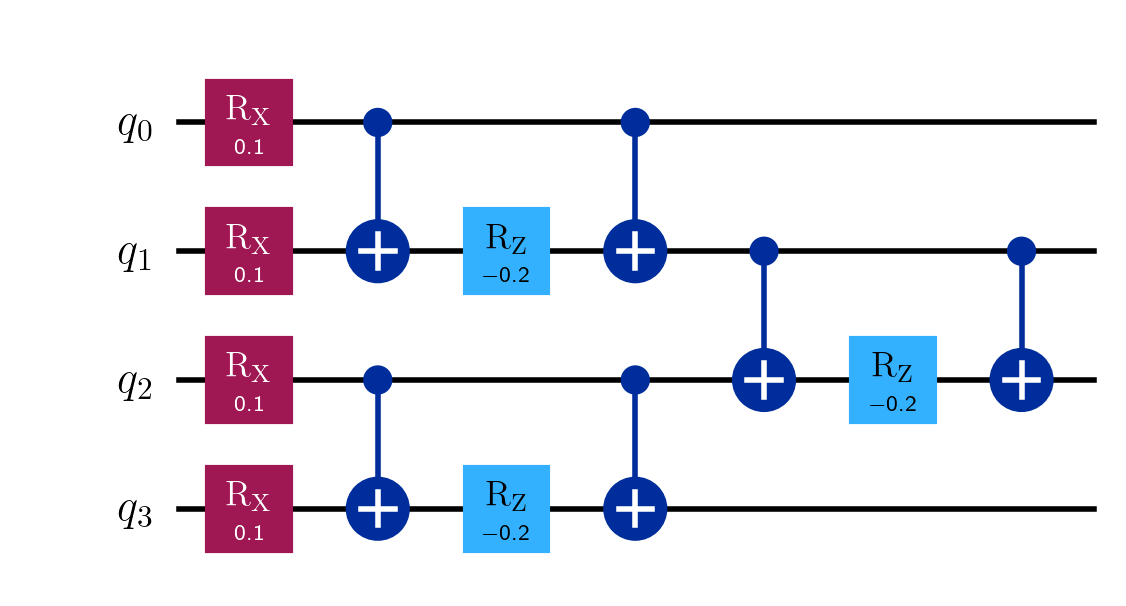

Trotter circuit with 2 Trotter steps


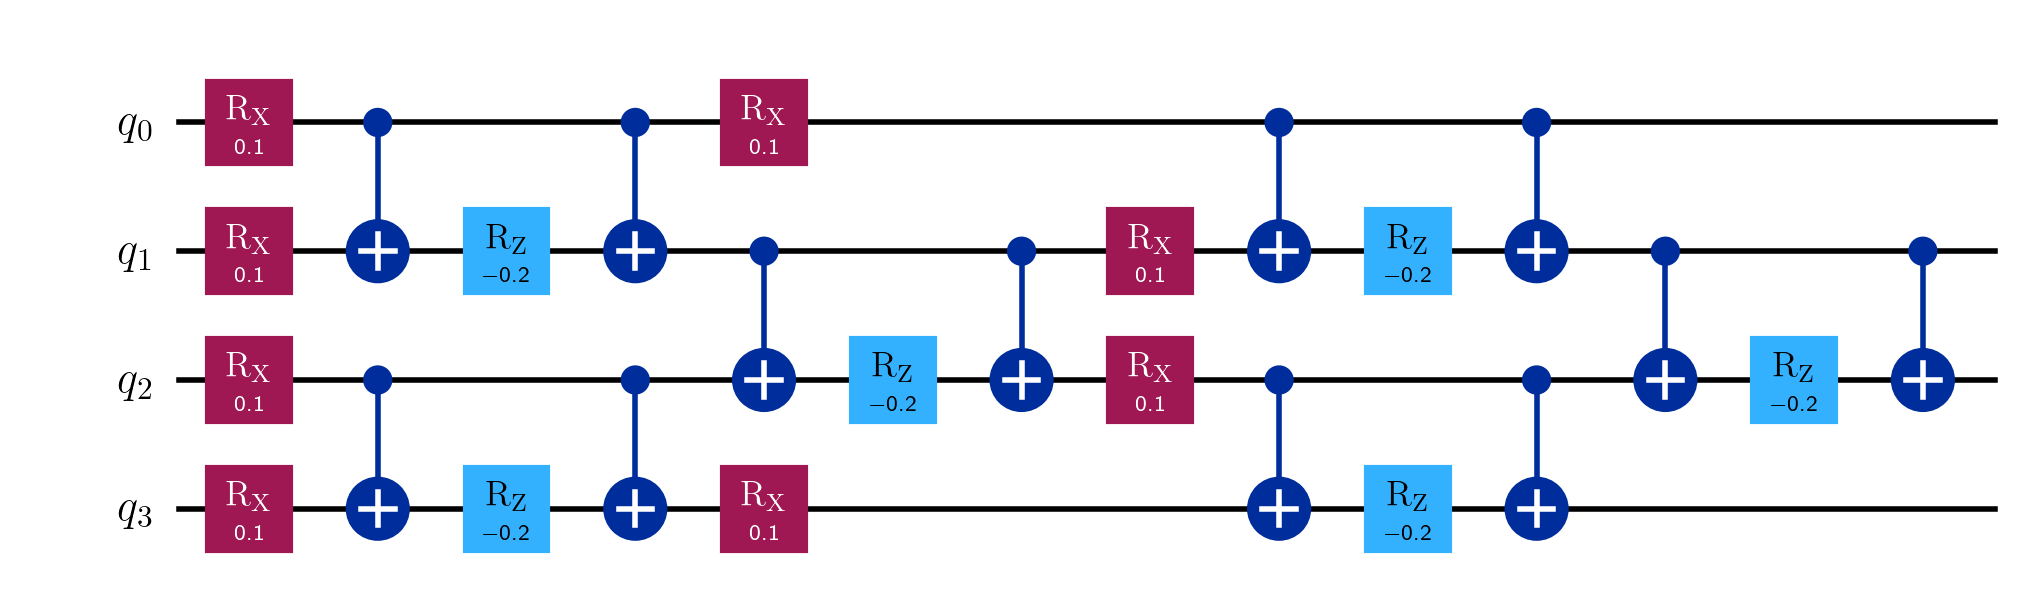

Trotter circuit with 3 Trotter steps


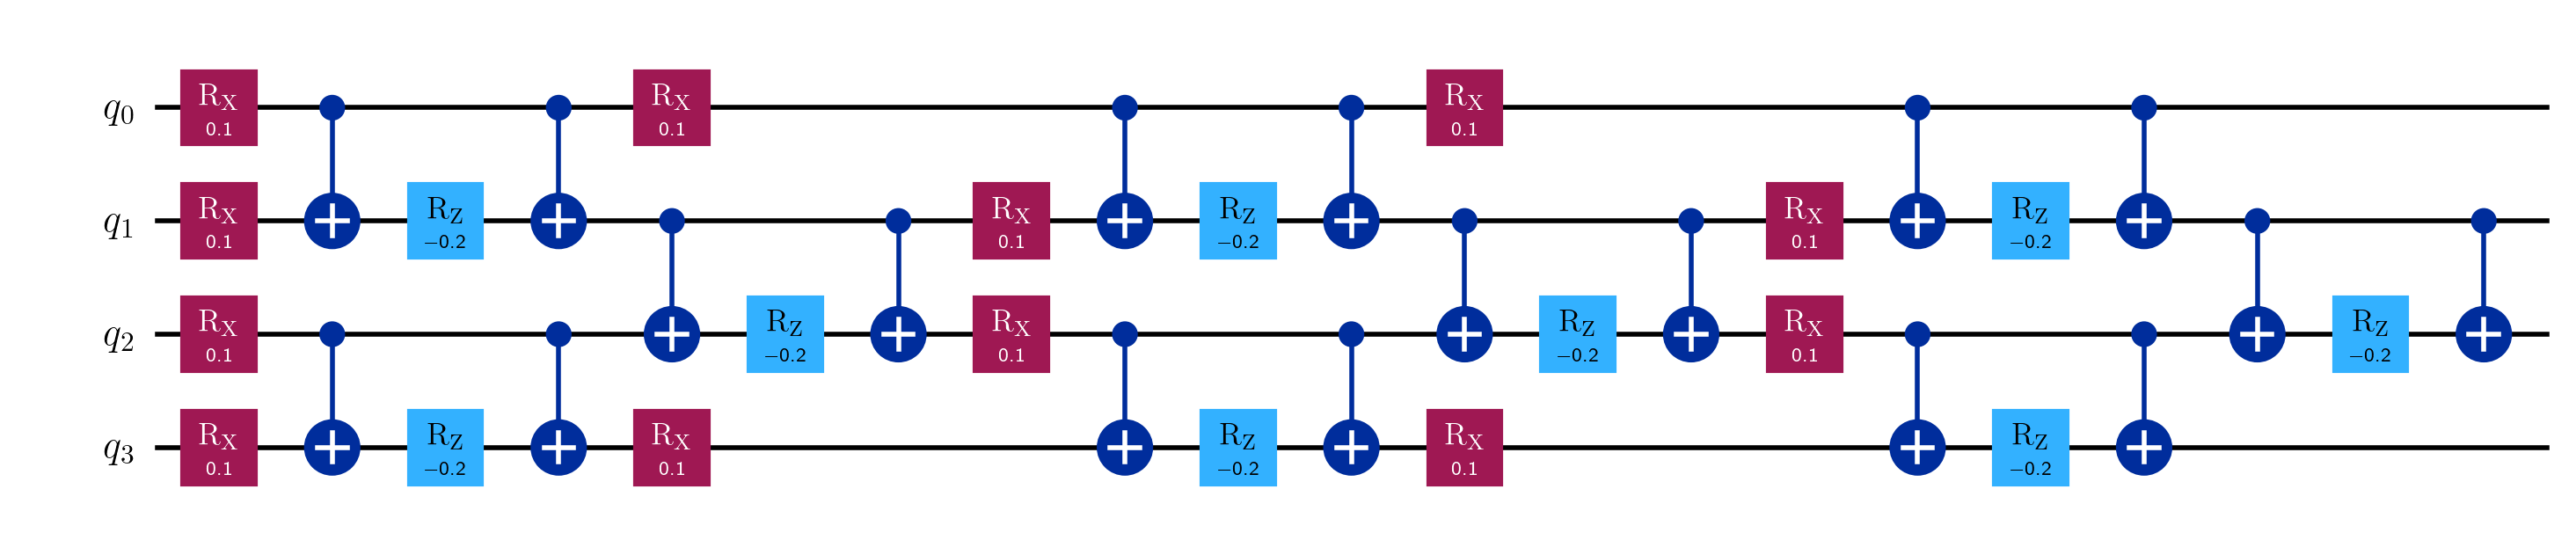

Trotter circuit with 4 Trotter steps


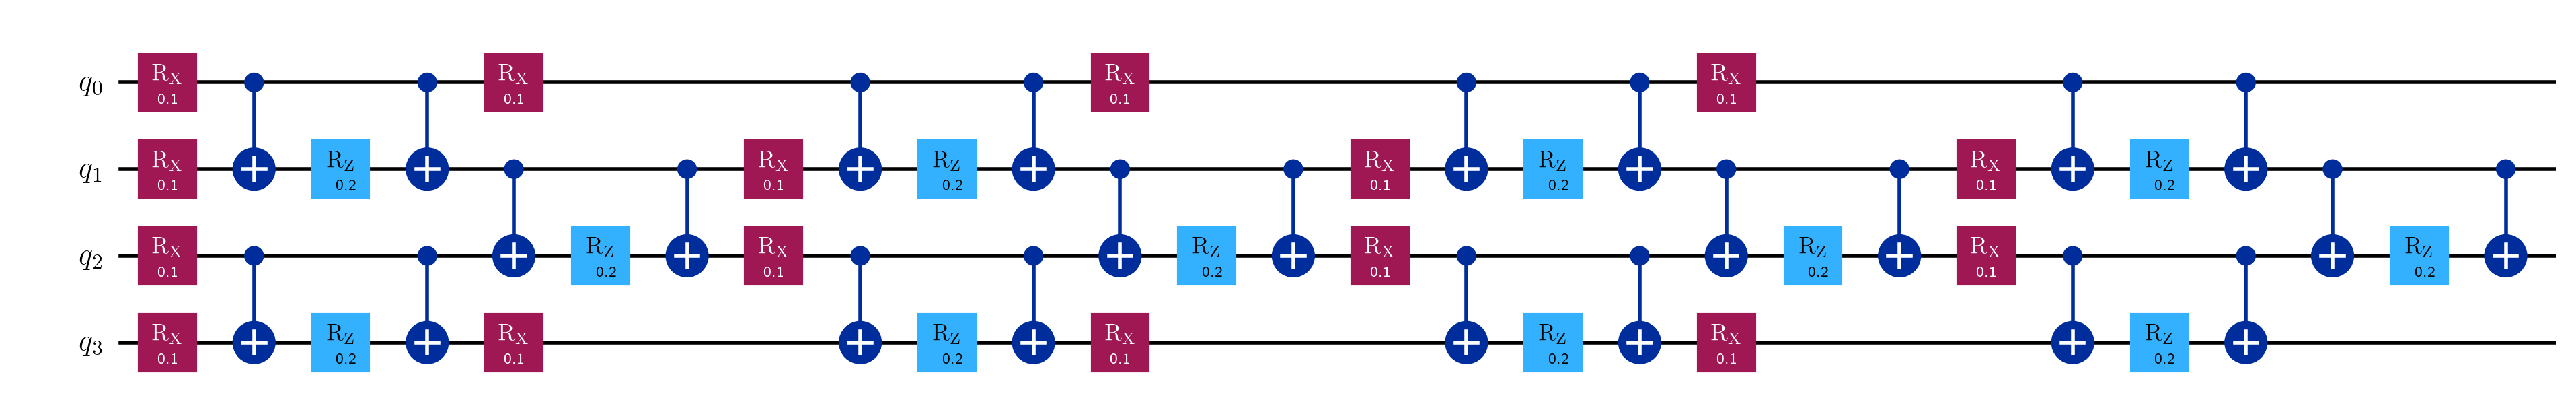

Trotter circuit with 5 Trotter steps


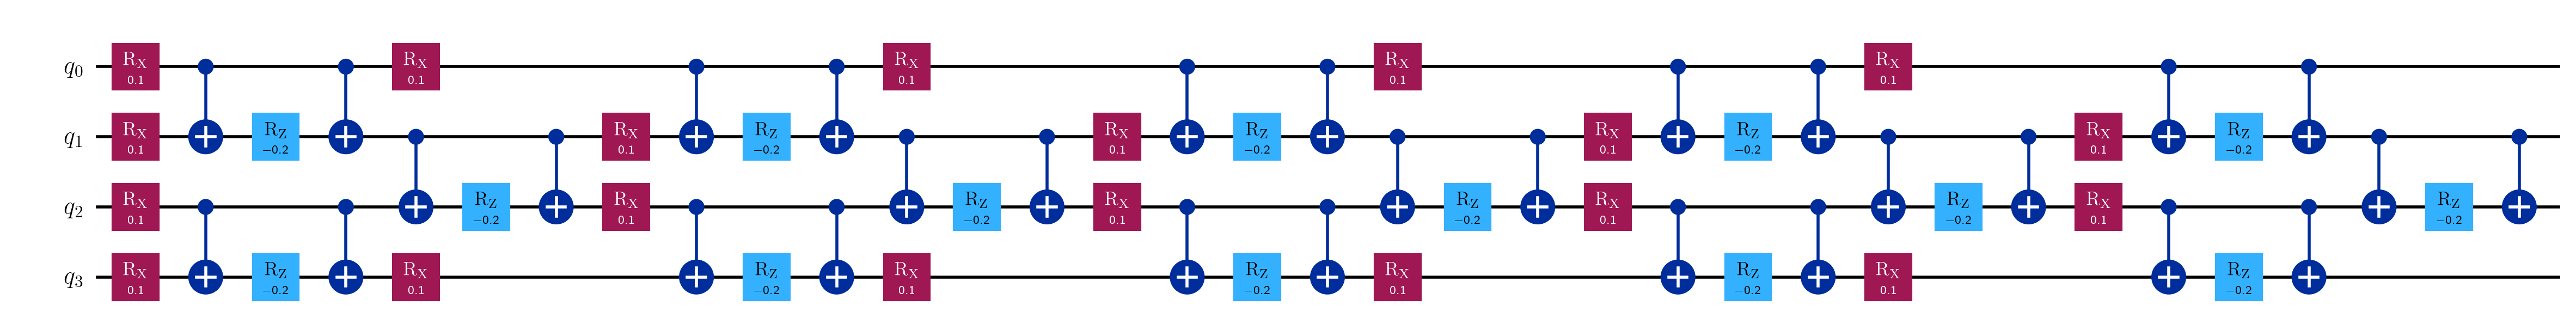

In [5]:
backend_simulator = "ibmq_qasm_simulator"
backend = "ibm_kyoto"

qubits = 4
trotter_layer = QuantumCircuit(qubits)
trotter_layer.rx(0.1, range(qubits))
trotter_layer.cx(0, 1)
trotter_layer.cx(2, 3)
trotter_layer.rz(-0.2, [1, 3])
trotter_layer.cx(0, 1)
trotter_layer.cx(2, 3)
trotter_layer.cx(1, 2)
trotter_layer.rz(-0.2, 2)
trotter_layer.cx(1, 2)

num_steps = 6
trotter_circuit_list = []
for i in range(1, num_steps):
    trotter_circuit = QuantumCircuit(qubits)
    for _ in range(i):
        trotter_circuit = trotter_circuit.compose(trotter_layer)
    trotter_circuit_list.append(trotter_circuit)
    print(f"Trotter circuit with {i} Trotter steps")
    display(trotter_circuit.draw(fold=-1))

obs = SparsePauliOp("Z" * qubits)
obs_list = [obs] * len(trotter_circuit_list)

In [6]:
#simulator run
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # No optimization
options.resilience_level = 0  # No mitigation

with Session(service=service, backend=backend_simulator) as session:
    estimator_sim = Estimator(session=session, options=options)
    job_sim = estimator_sim.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_sim.job_id)
    print(job_sim.result())

expvals_ideal = job_sim.result().values
expvals_ideal_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job_sim.result().metadata
]
std_error_ideal = np.sqrt(expvals_ideal_variance)

base_primitive._run_primitive:INFO:2024-02-27 13:35:31,267: Submitting job using options {'optimization_level': 0, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 0}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {}}


job id: <bound method JobV1.job_id of <RuntimeJob('cneua8vmo951g80h9ad0', 'estimator')>>
EstimatorResult(values=array([0.982, 0.936, 0.836, 0.762, 0.626]), metadata=[{'variance': 0.03567600000000004, 'shots': 1000}, {'variance': 0.1239039999999999, 'shots': 1000}, {'variance': 0.30110400000000004, 'shots': 1000}, {'variance': 0.41935599999999995, 'shots': 1000}, {'variance': 0.608124, 'shots': 1000}])


In [7]:
#Unmitigated, real backend
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # No optimization
options.resilience_level = 0  # No error mitigation
backend = "ibm_kyoto"
with Session(service=service, backend=backend) as session:
    estimator = Estimator(session=session, options=options)
    job = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job.job_id)
    print(job.result())

expvals_unmit = job.result().values
expvals_unmit_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job.result().metadata
]
std_error_unmit = np.sqrt(expvals_unmit_variance)

base_primitive._run_primitive:INFO:2024-02-27 13:35:36,736: Submitting job using options {'optimization_level': 0, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 0}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {}}
/opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:935: UserWarning: Starting a session using the /jobs endpoint will no longer be supported after March 31, 2024. Please update your code as soon as possible before this date. If you are using qiskit-ibm-runtime, you will need version 0.20.0 or higher. If you are using qiskit-ibm-provider, you will need version 0.10.0 or higher. If you are calling the API directly, please use the /sessions endpoint instead.
  warnings.warn(warning_message)


job id: <bound method JobV1.job_id of <RuntimeJob('cqeyaa93ptq000872jwg', 'estimator')>>
EstimatorResult(values=array([0.156, 0.134, 0.13 , 0.018, 0.012]), metadata=[{'variance': 0.975664, 'shots': 1000, 'warning': 'Circuits that do not match the target hardware definition will no longer be supported after March 1, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.'}, {'variance': 0.982044, 'shots': 1000, 'warning': 'Circuits that do not match the target hardware definition will no longer be supported after March 1, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.'}, {'variance': 0.9

In [8]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 3  # Dynamical decoupling
options.resilience_level = 0  # No error mitigation

with Session(service=service, backend=backend) as session:
    estimator = Estimator(session=session, options=options)
    job_dd = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_dd.job_id)
    print(job_dd.result())

expvals_unmit_dd = job_dd.result().values
expvals_unmit_dd_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job_dd.result().metadata
]
std_error_dd = np.sqrt(expvals_unmit_dd)

base_primitive._run_primitive:INFO:2024-02-27 13:47:05,032: Submitting job using options {'optimization_level': 3, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 3}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {}}


job id: <bound method JobV1.job_id of <RuntimeJob('cqeyfpp3ptq000872kbg', 'estimator')>>
EstimatorResult(values=array([0.318, 0.224, 0.168, 0.114, 0.04 ]), metadata=[{'variance': 0.898876, 'shots': 1000, 'warning': 'Circuits that do not match the target hardware definition will no longer be supported after March 1, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.\nOptimization level clipped from 3 to 1'}, {'variance': 0.949824, 'shots': 1000, 'warning': 'Circuits that do not match the target hardware definition will no longer be supported after March 1, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with opera

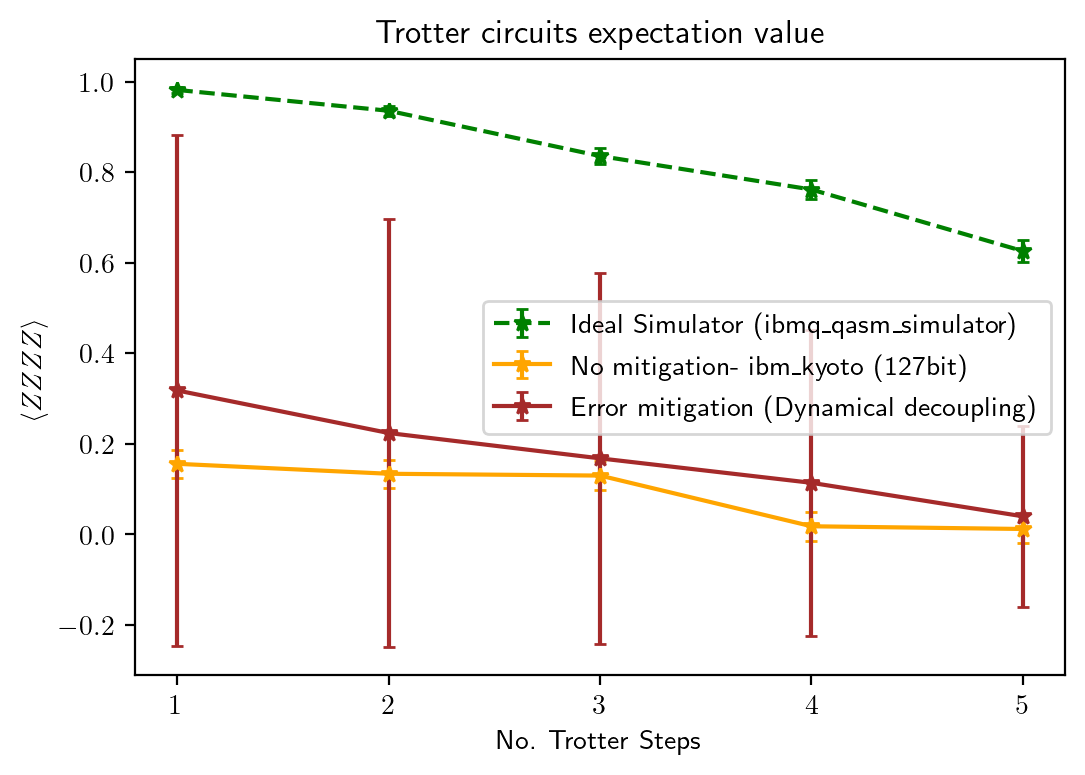

In [9]:
plt.title("Trotter circuits expectation value")
plt.errorbar(
    range(1, num_steps),
    expvals_ideal,
    std_error_ideal,
    fmt="*",
    linestyle="--",
    capsize=2,
    c="green",
    label="Ideal Simulator (ibmq_qasm_simulator)",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit,
    std_error_unmit,
    fmt="*",
    linestyle="-",
    capsize=2,
    c="orange",
    label="No mitigation- ibm_kyoto (127bit)",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit_dd,
    std_error_dd,
    fmt="*",
    linestyle="-",
    capsize=2,
    c="brown",
    label="Error mitigation (Dynamical decoupling)",
)

plt.ylabel(f"$\langle ZZZZ \\rangle$")
plt.xlabel("No. Trotter Steps")
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()

In [10]:
options = Options()
options.resilience_level = 1  # T-REx
options.optimization_level = 0  # No optimization
options.execution.shots = 1000

with Session(service=service, backend=backend) as session:
    estimator = Estimator(session=session, options=options)
    job_trex = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_trex.job_id)
    print(job_trex.result())

expvals_unmit_trex = job_trex.result().values
expvals_unmit_trex_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job_trex.result().metadata
]
std_error_trex = np.sqrt(expvals_unmit_trex_variance)

base_primitive._run_primitive:INFO:2024-02-27 13:53:11,399: Submitting job using options {'optimization_level': 0, 'resilience_level': 1, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 0}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {}}
/opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:935: UserWarning: Starting a session using the /jobs endpoint will no longer be supported after March 31, 2024. Please update your code as soon as possible before this date. If you are using qiskit-ibm-runtime, you will need version 0.20.0 or higher. If you are using qiskit-ibm-provider, you will need version 0.10.0 or higher. If you are calling the API directly, please use the /sessions endpoint instead.
  warnings.warn(warning_message)


job id: <bound method JobV1.job_id of <RuntimeJob('cqeyjj2xftxg0089bpy0', 'estimator')>>
EstimatorResult(values=array([0.81348821, 0.36330541, 0.30012186, 0.29222392, 0.01579589]), metadata=[{'variance': 15.183123940760066, 'shots': 1008, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192, 'warning': 'Circuits that do not match the target hardware definition will no longer be supported after March 1, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.'}, {'variance': 15.712896180789624, 'shots': 1008, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192, 'warning': 'Circuits that do not match the target hardware definition will no longer be supported after March 1, 2024. See the transpilation documentation (

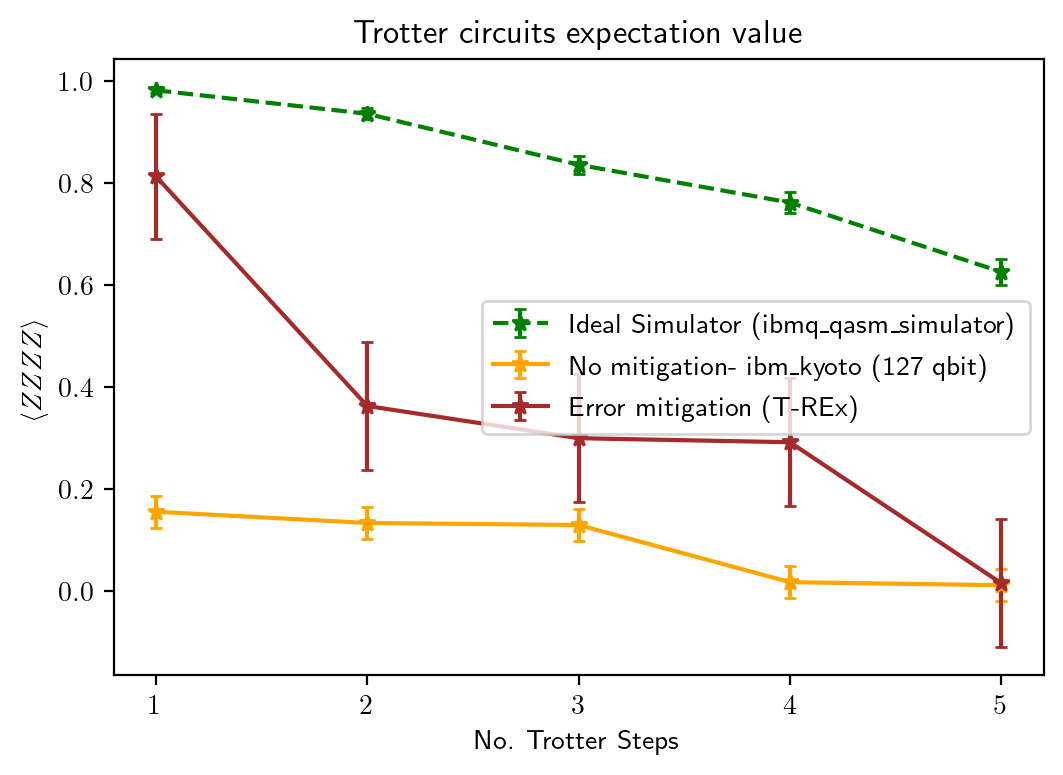

In [11]:
plt.title("Trotter circuits expectation value")
plt.errorbar(
    range(1, num_steps),
    expvals_ideal,
    std_error_ideal,
    fmt="*",
    linestyle="--",
    capsize=2,
    c="green",
    label="Ideal Simulator (ibmq_qasm_simulator)",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit,
    std_error_unmit,
    fmt="*",
    linestyle="-",
    capsize=2,
    c="orange",
    label="No mitigation- ibm_kyoto (127 qbit)",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit_trex,
    std_error_trex,
    fmt="*",
    linestyle="-",
    capsize=2,
    c="brown",
    label="Error mitigation (T-REx)",
)

plt.ylabel(f"$\langle ZZZZ \\rangle$")
plt.xlabel("No. Trotter Steps")
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()

In [12]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # No optimization
options.resilience_level = 2  # ZNE

with Session(service=service, backend=backend) as session:
    estimator = Estimator(session=session, options=options)
    job_zne = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_zne.job_id)
    print(job_zne.result())

expvals_unmit_zne = job_zne.result().values
# Standard error: coming soon!

base_primitive._run_primitive:INFO:2024-02-27 14:02:52,599: Submitting job using options {'optimization_level': 0, 'resilience_level': 2, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 0}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 2}, 'execution': {'shots': 1000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {}}
/opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:935: UserWarning: Starting a session using the /jobs endpoint will no longer be supported after March 31, 2024. Please update your code as soon as possible before this date. If you are using qiskit-ibm-runtime, you will need version 0.20.0 or higher. If you are using qiskit-ibm-provider, you will need version 0.10.0 or higher. If you are calling the API directly, please use the /s

job id: <bound method JobV1.job_id of <RuntimeJob('cqeyq3cxftxg0089bq60', 'estimator')>>
EstimatorResult(values=array([ 0.250053  ,  0.1109287 ,  0.13751127,  0.02333509, -0.03016454]), metadata=[{'std_error': 1.1795917001552145, 'zne': {'noise_amplification': {'noise_amplifier': "<TwoQubitAmplifier:{'barriers': True, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>", 'noise_factors': [1, 3, 5], 'values': [0.224, 0.2, 0.142], 'variance': [0.949824, 0.96, 0.979836], 'shots': [1000, 1000, 1000]}, 'extrapolation': {'extrapolator': 'LinearExtrapolator', 'coefficients': [0.250052998402385, -0.020455785537627266], 'covariance_matrix': [[1.3914365790750696, -0.3592851648977119], [-0.3592851648977119, 0.12059399377319445]], 'residuals': [-0.0055972128647577, 0.011314358210496811, -0.0057740707142486525], 'R2': 0.9457942461978649}}, 'warning': 'Circuits that do not match the target hardware definition will no longer be supported after March 1, 2

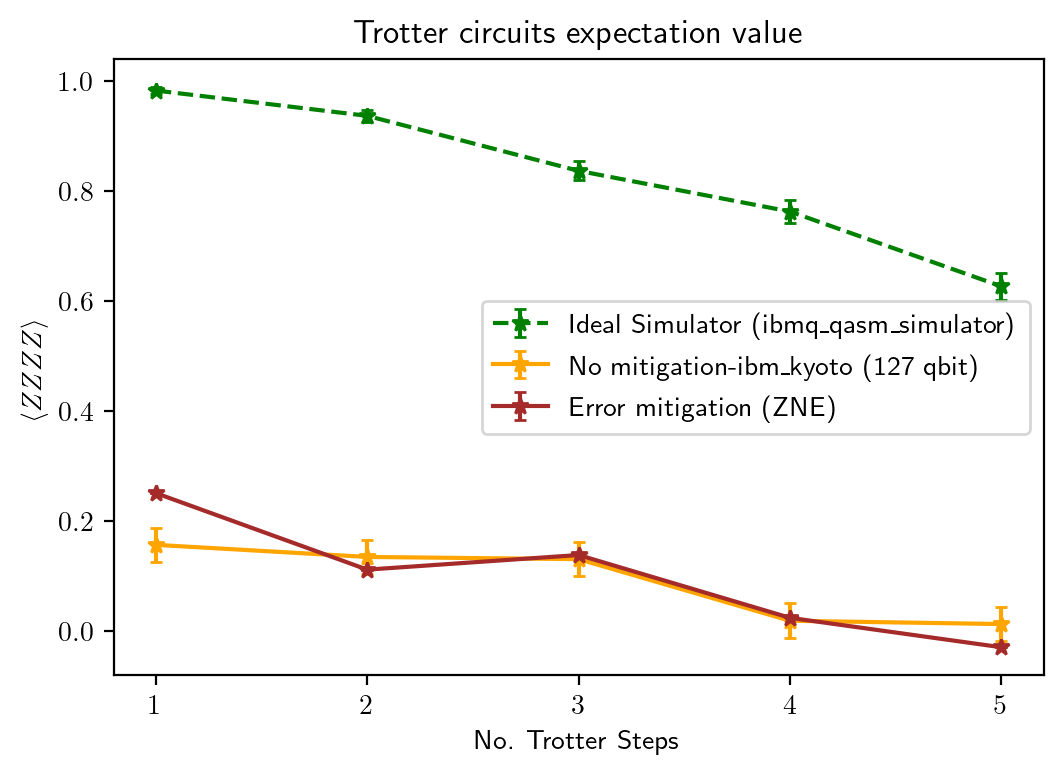

In [13]:
plt.title("Trotter circuits expectation value")
plt.errorbar(
    range(1, num_steps),
    expvals_ideal,
    std_error_ideal,
    fmt="*",
    linestyle="--",
    capsize=2,
    c="green",
    label="Ideal Simulator (ibmq_qasm_simulator)",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit,
    std_error_unmit,
    fmt="*",
    linestyle="-",
    capsize=2,
    c="orange",
    label="No mitigation-ibm_kyoto (127 qbit)",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit_zne,
    [0] * (num_steps - 1),
    fmt="*",
    linestyle="-",
    capsize=2,
    c="brown",
    label="Error mitigation (ZNE)",
)

plt.xlabel("No. Trotter Steps")
plt.ylabel(f"$\langle ZZZZ \\rangle$")
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()

In [14]:
def interim_results_callback(job_id, result):
    now = datetime.datetime.now()
    print(now, "*** Callback ***", result, "\n")


options = Options()
options.optimization_level = 0  # No optimization
options.execution.shots = 100
options.resilience_level = 3  # PEC
options.environment.callback = interim_results_callback

with Session(service=service, backend=backend) as session:
    estimator_pec = Estimator(session=session, options=options)
    job_pec = estimator_pec.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_pec.job_id)

expvals_pec = job_pec.result().values
std_error_pec = [metadata["standard_error"] for metadata in job_pec.result().metadata]

base_primitive._run_primitive:INFO:2024-02-27 14:13:47,040: Submitting job using options {'optimization_level': 0, 'resilience_level': 3, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 0}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 3}, 'execution': {'shots': 100, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': <function interim_results_callback at 0x7ff165226f80>, 'job_tags': []}, 'simulator': {}}
/opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:935: UserWarning: Starting a session using the /jobs endpoint will no longer be supported after March 31, 2024. Please update your code as soon as possible before this date. If you are using qiskit-ibm-runtime, you will need version 0.20.0 or higher. If you are using qiskit-ibm-provider, you will need version 0.10.0 or higher. If you are calling the API directly, please use the /s

job id: <bound method JobV1.job_id of <RuntimeJob('cqeyw70gtagg008qt3yg', 'estimator')>>


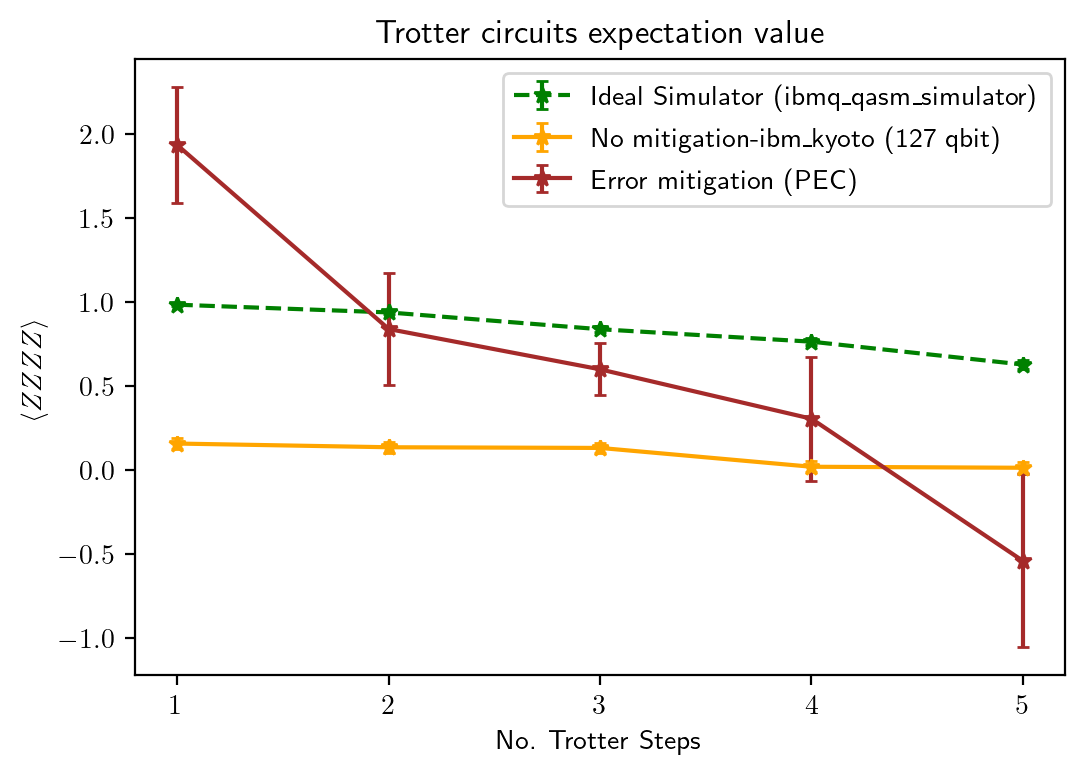

In [15]:
plt.title("Trotter circuits expectation value")
plt.errorbar(
    range(1, num_steps),
    expvals_ideal,
    std_error_ideal,
    fmt="*",
    linestyle="--",
    capsize=2,
    c="green",
    label="Ideal Simulator (ibmq_qasm_simulator)",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit,
    std_error_unmit,
    fmt="*",
    linestyle="-",
    capsize=2,
    c="orange",
    label="No mitigation-ibm_kyoto (127 qbit)",
)
plt.errorbar(
    range(1, num_steps),
    expvals_pec,
    std_error_pec,
    fmt="*",
    linestyle="-",
    capsize=2,
    c="brown",
    label="Error mitigation (PEC)",
)

plt.ylabel(f"$\langle ZZZZ \\rangle$")
plt.xlabel("No. Trotter Steps")
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()